<a href="https://colab.research.google.com/github/cblancovel/GAN_synth/blob/main/SDG_with_WGAN_GP_Carlos_Blanco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preprocessing**

In [ ]:
# %% [code]
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

# Load the dataset (assuming the dataset is in a CSV file)
file_path = "/content/drive/MyDrive/Fitbit/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv"  # Replace with your file path whatsoever
data = pd.read_csv(file_path)

# Convert 'ActivityDate' to the required datetime format (YYYY-MM-DD)
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Fill missing values
data.fillna({
    'VeryActiveDistance': 0,
    'ModeratelyActiveDistance': 0,
    'LightActiveDistance': 0,
    'VeryActiveMinutes': 0,
    'FairlyActiveMinutes': 0,
    'LightlyActiveMinutes': 0,
    'SedentaryMinutes': 0,
    'Calories': 0
}, inplace=True)

# Remove 'LoggedActivitiesDistance' and 'SedentaryActiveDistance' columns
data.drop(columns=['LoggedActivitiesDistance', 'SedentaryActiveDistance'], inplace=True)

# Normalize numerical features (scaling them between 0 and 1 for GAN training)
numerical_features = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance', 'VeryActiveDistance',
    'ModeratelyActiveDistance', 'LightActiveDistance', 'VeryActiveMinutes',
    'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'
]

# Encode 'Id' and keep it as the first column
data['Id_encoded'] = data['Id'].astype('category').cat.codes
data = data[['Id_encoded'] + [col for col in data.columns if col != 'Id_encoded']]

# Filter participants to include only the first 21 participants with 31 records
participant_counts = data['Id_encoded'].value_counts()
participants_with_31_records = participant_counts[participant_counts == 31].index[:21]
data = data[data['Id_encoded'].isin(participants_with_31_records)]

# Calculate zero percentage for each patient and filter out patients with >24.5% zeros
def calculate_zero_percentage(group):
    total_cells = group.size  # Total number of cells in the group
    zero_cells = (group == 0).sum().sum()  # Total number of cells with value 0
    return (zero_cells / total_cells) * 100  # Percentage of zeros

# Group by patient and calculate zero percentage
zero_percentages = data.groupby('Id_encoded').apply(calculate_zero_percentage)

# Filter patients with <= 24.5% zeros
valid_patients = zero_percentages[zero_percentages <= 24.5].index
data = data[data['Id_encoded'].isin(valid_patients)]

# Feature engineering: Add derived features (e.g., day of the week, month) without removing 'ActivityDate'
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'])  # Convert back to datetime for derived features
data['DayOfWeek'] = data['ActivityDate'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['Month'] = data['ActivityDate'].dt.month
data['ActivityDate'] = data['ActivityDate'].dt.strftime('%Y-%m-%d')  # Keep final format as YYYY-MM-DD

# Verify the preprocessed data
print("Processed DataFrame Head:")
print(data.head())

# Save preprocessed data for TimeGAN
preprocessed_file_path = "preprocessed_fitbit_data.csv"
data.to_csv(preprocessed_file_path, index=False)
print(f"Preprocessed data saved to {preprocessed_file_path}")


# %% [code]
import json

# Initialize the JSON structure
json_data = {}

# Ensure JSON generation uses the filtered data
# Group data by 'Id_encoded' and create JSON structure
for participant_id, group in data.groupby('Id_encoded'):
    # Create a list of dictionaries for this participant's time-series data
    participant_records = group.drop(columns='Id_encoded').to_dict(orient='records')
    # Add to the JSON structure
    json_data[f"participant_{participant_id}"] = participant_records


num_patients = len(data)
print(f"Number of patients in the JSON file: {num_patients}")
# Save the JSON to a file
output_json_path = "fitbit_data.json"
with open(output_json_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print(f"Data successfully converted to JSON format and saved to {output_json_path}")



Missing values per column:
Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64
Processed DataFrame Head:
   Id_encoded          Id ActivityDate  TotalSteps  TotalDistance  \
0           0  1503960366   2016-04-12       13162           8.50   
1           0  1503960366   2016-04-13       10735           6.97   
2           0  1503960366   2016-04-14       10460           6.74   
3           0  1503960366   2016-04-15        9762           6.28   
4           0  1503960366   2016-04-16       12669           8.16   

   TrackerDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0

<ipython-input-1-2e462a54eff9>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zero_percentages = data.groupby('Id_encoded').apply(calculate_zero_percentage)


Preprocessed data saved to preprocessed_fitbit_data.csv
Number of patients in the JSON file: 527
Data successfully converted to JSON format and saved to fitbit_data.json


WGAN-GP algorithm

Epoch [1/400], Critic Loss: 0.7957, Generator Loss: -0.2893
Epoch [11/400], Critic Loss: -1.8875, Generator Loss: 0.4530
Epoch [21/400], Critic Loss: -2.7236, Generator Loss: 0.0003
Epoch [31/400], Critic Loss: -0.4472, Generator Loss: -0.2394
Epoch [41/400], Critic Loss: -0.5356, Generator Loss: 0.7918
Epoch [51/400], Critic Loss: -0.3663, Generator Loss: 0.3132
Epoch [61/400], Critic Loss: -0.6621, Generator Loss: 0.3970
Epoch [71/400], Critic Loss: -0.5117, Generator Loss: 0.6200
Epoch [81/400], Critic Loss: -0.7070, Generator Loss: 0.2539
Epoch [91/400], Critic Loss: -0.6393, Generator Loss: 0.9020
Epoch [101/400], Critic Loss: -0.1746, Generator Loss: 1.0833
Epoch [111/400], Critic Loss: -0.7103, Generator Loss: 0.6905
Epoch [121/400], Critic Loss: -0.1727, Generator Loss: 1.5188
Epoch [131/400], Critic Loss: -0.1592, Generator Loss: 0.8876
Epoch [141/400], Critic Loss: -0.5830, Generator Loss: 1.8651
Epoch [151/400], Critic Loss: -0.3652, Generator Loss: 1.3343
Epoch [161/400], C

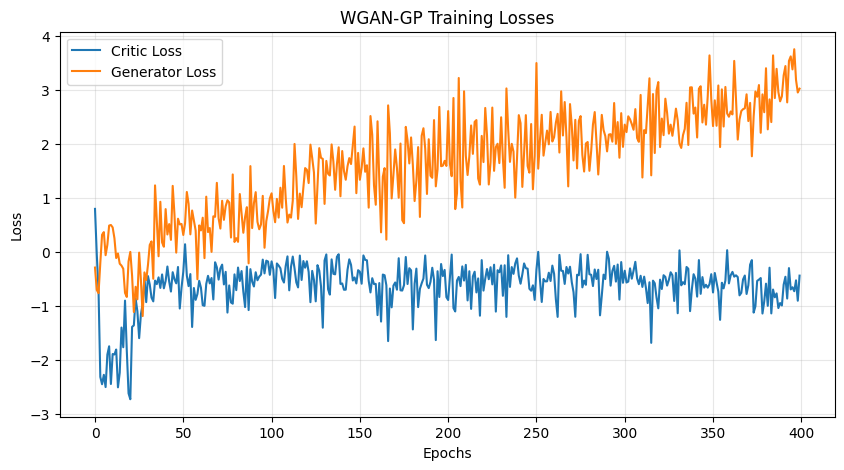

Synthetic data saved to improved_synthetic_fitbit_data.json


In [ ]:
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import random
import pandas as pd
import json
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = "preprocessed_fitbit_data.csv"
data = pd.read_csv(file_path)

# Extract relevant features
features = [
    "TotalSteps", "TotalDistance", "TrackerDistance",
    "VeryActiveDistance", "ModeratelyActiveDistance", "LightActiveDistance",
    "VeryActiveMinutes", "FairlyActiveMinutes",
    "LightlyActiveMinutes", "SedentaryMinutes", "Calories", "DayOfWeek", "Month"
]

date_features = ["DayOfWeek", "Month", "ActivityDate"]

data_values = data[features].values

# Apply RobustScaler for normalization
robust_scaler = RobustScaler()
data_normalized = robust_scaler.fit_transform(data_values)

# Convert normalized data to tensor
data_tensor = torch.tensor(data_normalized, dtype=torch.float32)

# Extract original date-related fields
date_data = data[date_features].drop_duplicates().reset_index(drop=True)
activity_dates = date_data["ActivityDate"].tolist()
day_of_week = date_data["DayOfWeek"].tolist()
month = date_data["Month"].tolist()

# Create DataLoader
batch_size = 128
data_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
#set_seed(42)  # Set the seed for reproducibility

# Define the Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic (Discriminator in WGAN-GP)
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Gradient Penalty Function
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)  # Match the shape of real_data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.clone().detach().requires_grad_(True)  # Create a leaf tensor with requires_grad

    critic_interpolates = critic(interpolates)
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates, device=real_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

# Hyperparameters
noise_dim = 25
data_dim = len(features)
num_epochs = 400  # Ensure this matches your desired epochs
lr = 0.0002
lambda_gp = 5  # Gradient penalty coefficient
critic_updates = 8  # Number of critic updates per generator update
generator_updates = 2  # Increased generator updates

# Instantiate models
generator = Generator(noise_dim, data_dim)
critic = Critic(data_dim)

# Optimizers
optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

# Initialize lists to store losses
critic_losses = []
generator_losses = []

# Updated Training Loop
for epoch in range(num_epochs):
    for real_data, in data_loader:
        real_data = real_data.to(generator.model[0].weight.device)
        batch_size = real_data.size(0)

        # Train Critic
        for _ in range(critic_updates):
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            real_score = critic(real_data)
            fake_score = critic(fake_data.detach())
            gp = gradient_penalty(critic, real_data, fake_data)
            critic_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
            optim_critic.zero_grad()
            critic_loss.backward()
            optim_critic.step()

        # Train Generator (multiple updates per critic step)
        for _ in range(generator_updates):
            noise = torch.randn(batch_size, noise_dim, device=real_data.device)
            fake_data = generator(noise)
            gen_loss = -critic(fake_data).mean()
            optim_gen.zero_grad()
            gen_loss.backward()
            optim_gen.step()

    # Log losses once per epoch
    critic_losses.append(critic_loss.item())
    generator_losses.append(gen_loss.item())

    if epoch % 10 == 0:  # Adjust print frequency as needed
        print(f"Epoch [{epoch+1}/{num_epochs}], Critic Loss: {critic_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(len(critic_losses)), critic_losses, label="Critic Loss")
plt.plot(range(len(generator_losses)), generator_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Losses")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Generate Synthetic Data ---
num_participants = 200
num_days = 31
synthetic_data = []

for participant_id in range(num_participants):
    participant_records = []
    for i, date in enumerate(activity_dates):
        noise = torch.randn(1, noise_dim, device=generator.model[0].weight.device)
        generated = generator(noise).detach().cpu().numpy().flatten()
        generated = robust_scaler.inverse_transform([generated])[0]  # Reverse transform to original scale
        generated = np.clip(generated, 0, None)
        record = {
            "Id": participant_id + 1,
            "ActivityDate": date,
            "TotalSteps": int(generated[0]),
            "TotalDistance": float(generated[1]),
            "TrackerDistance": float(generated[2]),
            "VeryActiveDistance": float(generated[3]),
            "ModeratelyActiveDistance": float(generated[4]),
            "LightActiveDistance": float(generated[5]),
            "VeryActiveMinutes": float(generated[6]),
            "FairlyActiveMinutes": float(generated[7]),
            "LightlyActiveMinutes": float(generated[8]),
            "SedentaryMinutes": float(generated[9]),
            "Calories": int(generated[10]),
            "DayOfWeek": day_of_week[i % len(day_of_week)],
            "Month": month[i % len(month)],
        }
        participant_records.append(record)
    synthetic_data.append({f"participant_{participant_id}": participant_records})

# Save to JSON
output_json_path = "improved_synthetic_fitbit_data.json"
with open(output_json_path, "w") as json_file:
    json.dump(synthetic_data, json_file, indent=4)

print(f"Synthetic data saved to {output_json_path}")



Evaluation - Resemblance

Kullback-Leibler Divergence: 12.2633
Jensen-Shannon Divergence: 0.7980
Earth Mover's Distance (EMD): 206.2081
R2 Score: -0.9345
Mean Absolute Error (MAE): 5179.0342
Pearson Correlation Coefficient: 0.0125

Moments Comparison:
Mean - Original: 9125.8330, Synthetic: 8913.3454
Variance - Original: 23812598.1163, Synthetic: 22790492.8864
Skewness - Original: 0.8836, Synthetic: 0.8070
Kurtosis - Original: 2.2323, Synthetic: 1.2248

Original Data KS Test against Normal Distribution
Statistic: 0.0551, p-value: 0.0787

KS Test between Original and Synthetic Data
Statistic: 0.0645, p-value: 0.2229


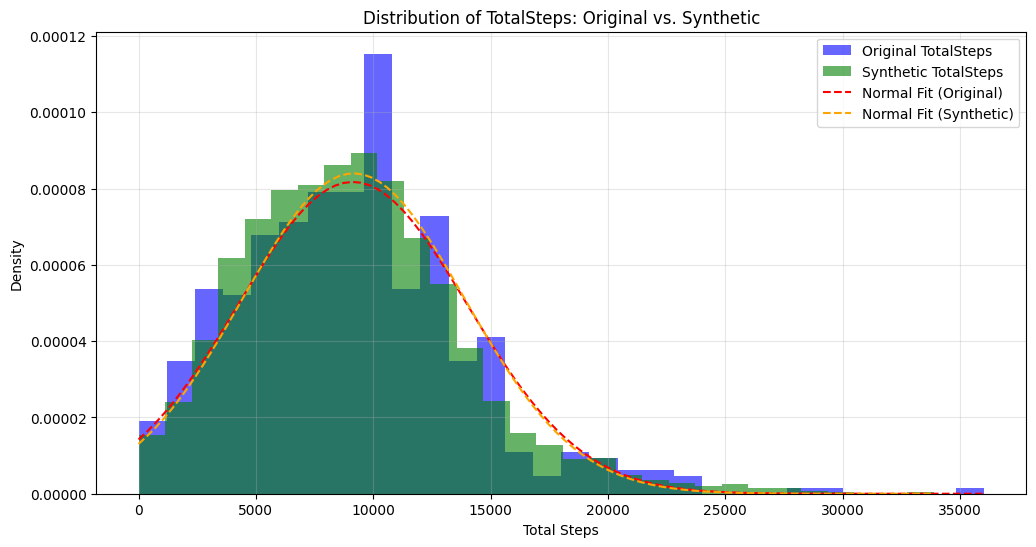

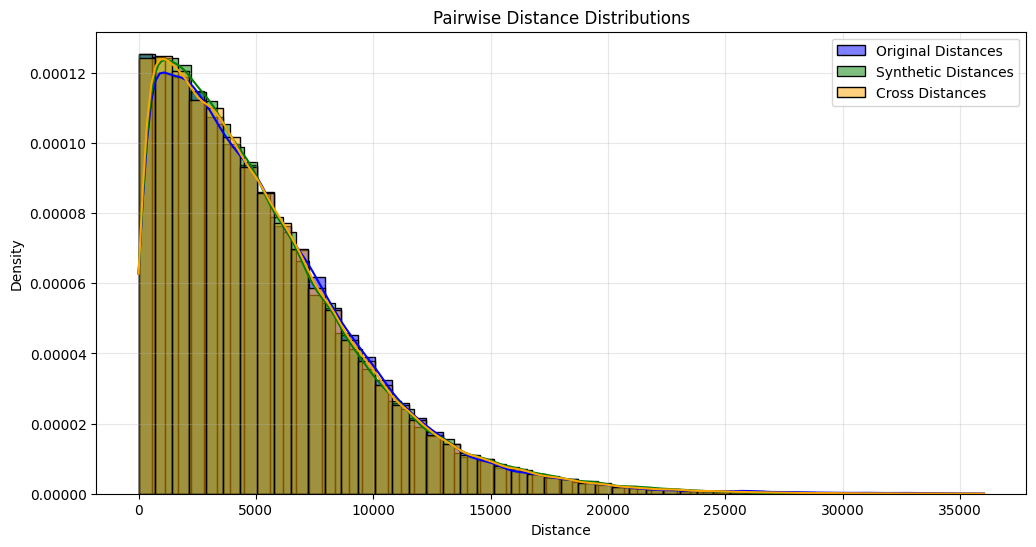

Spearman Correlation: 0.0413

Correlation Preservation: TotalSteps                  9.09
TotalDistance               9.09
TrackerDistance             9.09
VeryActiveDistance          9.09
ModeratelyActiveDistance    9.09
LightActiveDistance         9.09
VeryActiveMinutes           9.09
FairlyActiveMinutes         9.09
LightlyActiveMinutes        9.09
SedentaryMinutes            9.09
Calories                    9.09
dtype: float64%


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


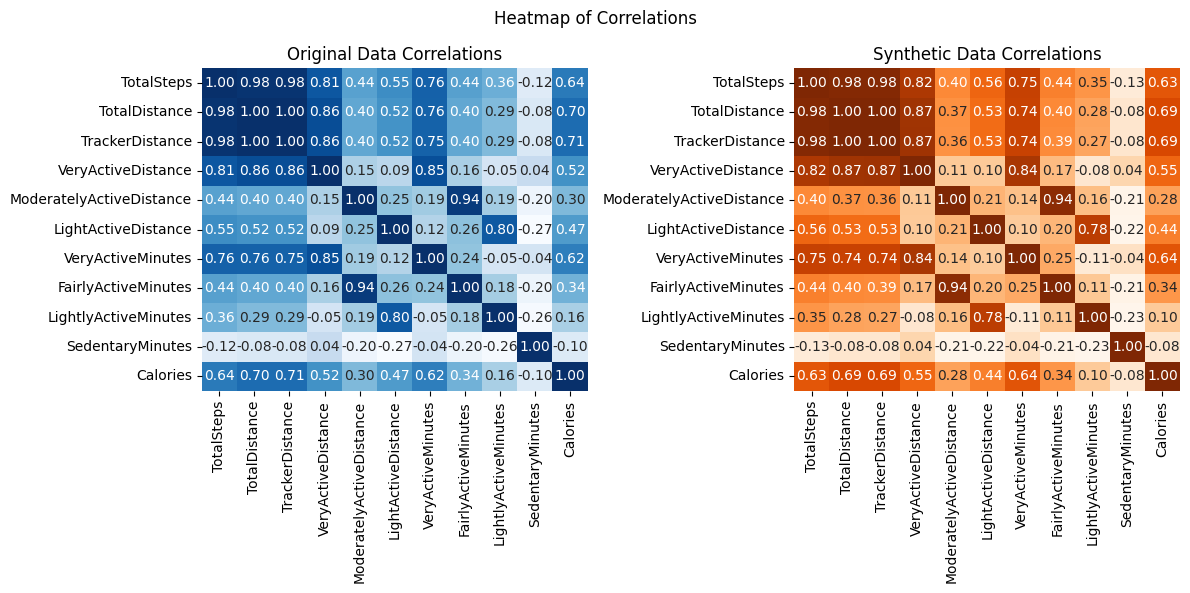

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance, pearsonr, spearmanr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import random
import json


# Load original data from JSON
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load synthetic data from JSON
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Exclude irrelevant columns
irrelevant_columns = ['Id', 'Month', 'DayOfWeek']
original_df = original_df.drop(columns=[col for col in irrelevant_columns if col in original_df.columns], errors='ignore')
synthetic_df = synthetic_df.drop(columns=[col for col in irrelevant_columns if col in synthetic_df.columns], errors='ignore')

# Focus on the 'TotalSteps' column for evaluation
original_steps = original_df['TotalSteps']
synthetic_steps = synthetic_df['TotalSteps']
# Downsample synthetic data to match original data size
#random.seed(42)
synthetic_steps_downsampled = synthetic_steps.sample(n=len(original_steps), random_state=42)

# --- Distribution Metrics ---
# Align the value counts of both datasets
original_counts = original_steps.value_counts(normalize=True)
synthetic_counts = synthetic_steps.value_counts(normalize=True)

# Create a union of the indices (unique values)
all_indices = original_counts.index.union(synthetic_counts.index)

# Reindex both counts to ensure they have the same indices
original_counts = original_counts.reindex(all_indices, fill_value=0)
synthetic_counts = synthetic_counts.reindex(all_indices, fill_value=0)

# Kullback-Leibler (KL) Divergence with smoothing to avoid `inf`
epsilon = 1e-10
kl_divergence = entropy(original_counts + epsilon, synthetic_counts + epsilon)
print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")

# Jensen-Shannon (JS) Divergence
js_divergence = jensenshannon(original_counts, synthetic_counts)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Earth Mover's Distance (Wasserstein Distance)
emd = wasserstein_distance(original_steps, synthetic_steps)
print(f"Earth Mover's Distance (EMD): {emd:.4f}")

# --- Additional Metrics ---
# R2 Score
r2 = r2_score(original_steps, synthetic_steps_downsampled)
print(f"R2 Score: {r2:.4f}")

# Mean Absolute Error
mae = mean_absolute_error(original_steps, synthetic_steps_downsampled)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(original_steps, synthetic_steps_downsampled)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")

# --- Moments Comparison ---
mean_original, mean_synthetic = np.mean(original_steps), np.mean(synthetic_steps_downsampled)
variance_original, variance_synthetic = np.var(original_steps), np.var(synthetic_steps_downsampled)
skewness_original, skewness_synthetic = original_steps.skew(), synthetic_steps_downsampled.skew()
kurtosis_original, kurtosis_synthetic = original_steps.kurtosis(), synthetic_steps_downsampled.kurtosis()

print("\nMoments Comparison:")
print(f"Mean - Original: {mean_original:.4f}, Synthetic: {mean_synthetic:.4f}")
print(f"Variance - Original: {variance_original:.4f}, Synthetic: {variance_synthetic:.4f}")
print(f"Skewness - Original: {skewness_original:.4f}, Synthetic: {skewness_synthetic:.4f}")
print(f"Kurtosis - Original: {kurtosis_original:.4f}, Synthetic: {kurtosis_synthetic:.4f}")

# Perform KS Test against a normal distribution (original dataset)
std_original = np.std(original_steps)
ks_test_original = kstest(original_steps, lambda x: norm.cdf(x, loc=mean_original, scale=std_original))
print("\nOriginal Data KS Test against Normal Distribution")
print(f"Statistic: {ks_test_original.statistic:.4f}, p-value: {ks_test_original.pvalue:.4f}")

# Perform KS Test between original and synthetic datasets
ks_test_comparison = ks_2samp(original_steps, synthetic_steps_downsampled)
print("\nKS Test between Original and Synthetic Data")
print(f"Statistic: {ks_test_comparison.statistic:.4f}, p-value: {ks_test_comparison.pvalue:.4f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation for synthetic data
mean_synthetic = np.mean(synthetic_steps)
std_synthetic = np.std(synthetic_steps)

# Plot Original Distribution
plt.hist(original_steps, bins=30, density=True, alpha=0.6, label='Original TotalSteps', color='blue')

# Plot Synthetic Distribution
plt.hist(synthetic_steps, bins=30, density=True, alpha=0.6, label='Synthetic TotalSteps', color='green')

# Plot Normal Fit for Original Data
x_original = np.linspace(min(original_steps), max(original_steps), 100)
plt.plot(x_original, norm.pdf(x_original, loc=mean_original, scale=std_original),
         label='Normal Fit (Original)', color='red', linestyle='--')

# Plot Normal Fit for Synthetic Data
x_synthetic = np.linspace(min(synthetic_steps), max(synthetic_steps), 100)
plt.plot(x_synthetic, norm.pdf(x_synthetic, loc=mean_synthetic, scale=std_synthetic),
         label='Normal Fit (Synthetic)', color='orange', linestyle='--')

# Add Labels and Legend
plt.title('Distribution of TotalSteps: Original vs. Synthetic')
plt.xlabel('Total Steps')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


from sklearn.metrics import pairwise_distances
import seaborn as sns

# Compute pairwise distances within each dataset
original_distances = pairwise_distances(original_steps.values.reshape(-1, 1))
synthetic_distances = pairwise_distances(synthetic_steps_downsampled.values.reshape(-1, 1))

# Compute pairwise distances between original and synthetic data
cross_distances = pairwise_distances(
    original_steps.values.reshape(-1, 1),
    synthetic_steps_downsampled.values.reshape(-1, 1)
)

# Flatten distance matrices for visualization
original_distances_flat = original_distances[np.triu_indices_from(original_distances, k=1)]
synthetic_distances_flat = synthetic_distances[np.triu_indices_from(synthetic_distances, k=1)]
cross_distances_flat = cross_distances.flatten()

# Visualize distances using histograms
plt.figure(figsize=(12, 6))
sns.histplot(original_distances_flat, bins=50, kde=True, label='Original Distances', color='blue', stat='density')
sns.histplot(synthetic_distances_flat, bins=50, kde=True, label='Synthetic Distances', color='green', stat='density')
sns.histplot(cross_distances_flat, bins=50, kde=True, label='Cross Distances', color='orange', stat='density')
plt.title('Pairwise Distance Distributions')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Compute Spearman correlation
spearman_corr, _ = spearmanr(original_steps, synthetic_steps_downsampled)
print(f"Spearman Correlation: {spearman_corr:.4f}")

# --- Correlation Analysis ---
def correlation_analysis(df):
    return df.corr(method='pearson')

original_corr = correlation_analysis(original_df.select_dtypes(include=[np.number]))
synthetic_corr = correlation_analysis(synthetic_df.select_dtypes(include=[np.number]))

# Compute correlation preservation
def compute_correlation_preservation(original_corr, synthetic_corr):
    diff = np.abs(original_corr - synthetic_corr)
    preserved = np.sum(diff < 0.1) / (len(original_corr)**2)
    return np.round(preserved * 100, 2)

correlation_preservation = compute_correlation_preservation(original_corr, synthetic_corr)
print(f"\nCorrelation Preservation: {correlation_preservation}%")
# Heatmap of Correlations
plt.figure(figsize=(12, 6))
plt.suptitle('Heatmap of Correlations')

plt.subplot(1, 2, 1)
sns.heatmap(original_corr, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title('Original Data Correlations')

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=True, fmt=".2f", cmap="Oranges", cbar=False)
plt.title('Synthetic Data Correlations')

plt.tight_layout()
plt.show()


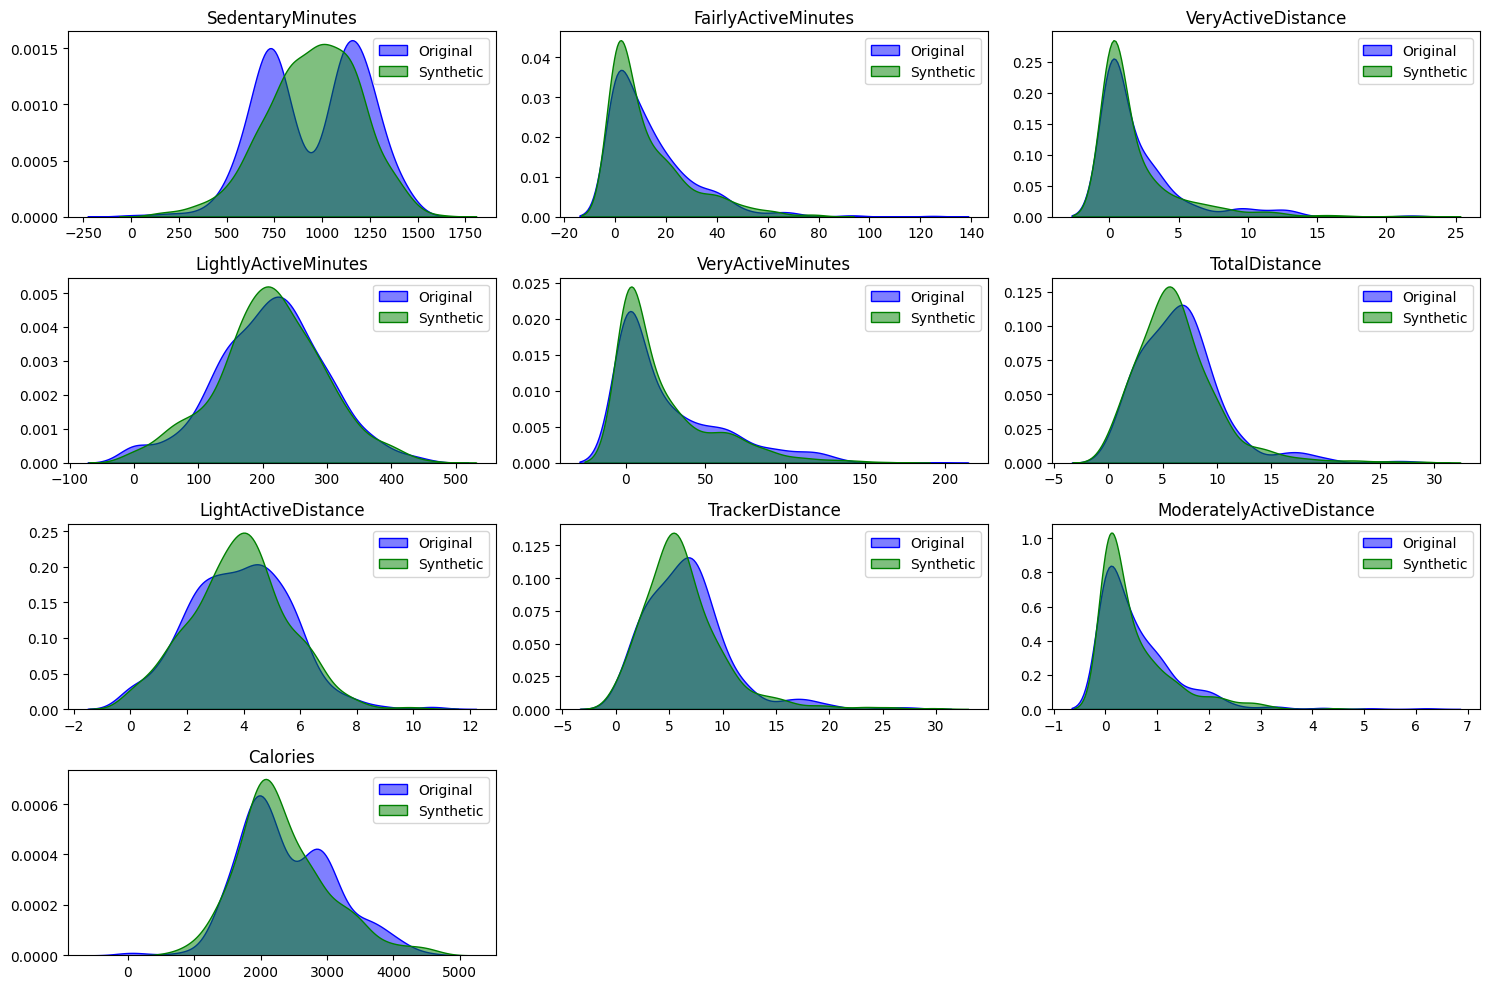


--- Evaluation Metrics for Each Feature ---
                          KL Divergence  JS Divergence        EMD  R2 Score  \
SedentaryMinutes               0.848436       0.138103  51.657139 -0.745248   
FairlyActiveMinutes            0.090481       0.559422   1.514687 -0.956739   
VeryActiveDistance             0.209054       0.587675   0.254914 -0.761795   
LightlyActiveMinutes           0.077782       0.218316   4.118045 -0.926254   
VeryActiveMinutes              0.065479       0.560588   4.239612 -0.703525   
TotalDistance                  0.127844       0.288860   0.355110 -0.889189   
LightActiveDistance            0.103387       0.248119   0.130181 -0.907200   
TrackerDistance                0.184289       0.286573   0.408847 -0.884485   
ModeratelyActiveDistance       0.092115       0.561079   0.086229 -0.883611   
Calories                       0.370828       0.149125  86.643264 -0.943189   

                                 MAE  Pearson Correlation  
SedentaryMinutes         

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp, norm, entropy, wasserstein_distance, pearsonr
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json

# Load and Preprocess Data
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

def load_dataframe(data):
    frames = []
    if isinstance(data, list):
        for participant_data in data:
            for participant, records in participant_data.items():
                df = pd.DataFrame(records)
                df['Participant'] = participant
                frames.append(df)
    else:
        for participant, records in data.items():
            df = pd.DataFrame(records)
            df['Participant'] = participant
            frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Load data into DataFrames
original_df = load_dataframe(original_data)
synthetic_df = load_dataframe(synthetic_data)

# Exclude irrelevant columns
irrelevant_columns = ['Id', 'Month', 'DayOfWeek']
original_df = original_df.drop(columns=[col for col in irrelevant_columns if col in original_df.columns], errors='ignore')
synthetic_df = synthetic_df.drop(columns=[col for col in irrelevant_columns if col in synthetic_df.columns], errors='ignore')

# Features for evaluation
features = original_df.select_dtypes(include=[np.number]).columns

# --- Metrics and Visualization ---

# Downsample synthetic data to match original size
synthetic_downsampled = synthetic_df.sample(n=len(original_df), random_state=42)


# Set grid layout
rows = 4
cols = 3
num_plots = len(features) if len(features) < 10 else 10  # Limit to 10 features
plot_features = random.sample(list(features), num_plots)  # Randomly sample 10 features if more exist

# Initialize results dictionary
results = {}

# Set figure size for small boxes
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Loop through features and plot
for idx, feature in enumerate(plot_features):
    original_values = original_df[feature].dropna()
    synthetic_values = synthetic_downsampled[feature].dropna()

    # Metrics Calculation
    kl_divergence = entropy(np.histogram(original_values, bins=30, density=True)[0] + 1e-10,
                            np.histogram(synthetic_values, bins=30, density=True)[0] + 1e-10)
    js_divergence = jensenshannon(original_values, synthetic_values)
    emd = wasserstein_distance(original_values, synthetic_values)
    r2 = r2_score(original_values, synthetic_values)
    mae = mean_absolute_error(original_values, synthetic_values)
    pearson_corr, _ = pearsonr(original_values, synthetic_values)

    # Store results
    results[feature] = {
        'KL Divergence': kl_divergence,
        'JS Divergence': js_divergence,
        'EMD': emd,
        'R2 Score': r2,
        'MAE': mae,
        'Pearson Correlation': pearson_corr
    }

    # Visualization (Small Density Plot)
    sns.kdeplot(original_values, label='Original', fill=True, alpha=0.5, color='blue', ax=axes[idx])
    sns.kdeplot(synthetic_values, label='Synthetic', fill=True, alpha=0.5, color='green', ax=axes[idx])
    axes[idx].set_title(f"{feature}")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    axes[idx].legend()

    # Save each individual graph
    plt.savefig(f"feature_{feature}.png", bbox_inches='tight')

# Remove unused axes if any
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Print Results Table
print("\n--- Evaluation Metrics for Each Feature ---")
results_df = pd.DataFrame(results).T
print(results_df)


Evaluation - Utility

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Model Performance on TotalSteps (Binary Classification):
                Model    Dataset  Accuracy  F1-Score   ROC AUC
0        RandomForest   Original  0.981132  0.982456  0.997143
1  LogisticRegression   Original  0.924528  0.928571  0.987857
2       MLPClassifier   Original  0.952830  0.954955  0.991786
3        RandomForest  Synthetic  0.962264  0.963636  0.998750
4  LogisticRegression  Synthetic  0.971698  0.972477  0.999286
5       MLPClassifier  Synthetic  0.962264  0.962963  0.996786

Performance Differences Between Original and Synthetic Data:
   Accuracy Diff  F1-Score Diff  ROC AUC Diff               Model
0       0.018868       0.018820      0.001607        RandomForest
1       0.047170       0.043906      0.011429  LogisticRegression
2       0.009434       0.008008      0.005000       MLPClassifier


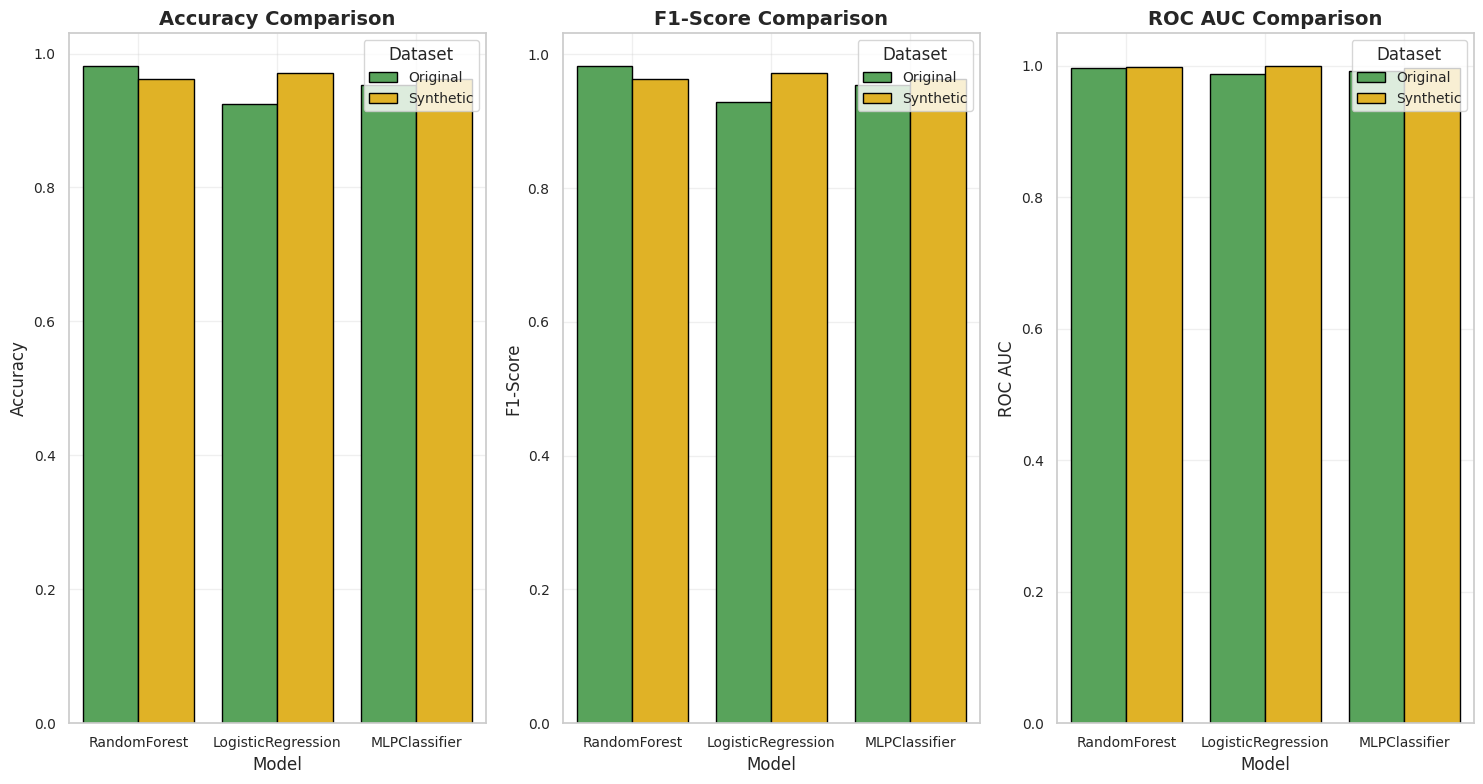

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load Original Data
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert Original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load Synthetic Data
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert Synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Binary Target Generation for TotalSteps (Example threshold for classification)
threshold = 10000  # Adjust threshold for your task
original_df['Target'] = (original_df['TotalSteps'] > threshold).astype(int)
synthetic_df['Target'] = (synthetic_df['TotalSteps'] > threshold).astype(int)

# Features and Target
target_column = 'Target'
features = ['TotalDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance',
            'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
            'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'DayOfWeek', 'Month']

# Step 1: Split Original Data into Train and Test
X_original = original_df[features]
y_original = original_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Step 2: Prepare Synthetic Data for Training
X_synthetic = synthetic_df[features]
y_synthetic = synthetic_df[target_column]

# Step 3: Initialize Classification Models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

# Step 4: Train and Evaluate Models
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    results = []
    for model_name, model in models.items():
        # Standardize Data for Logistic and MLP Classifiers
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train Model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

        # Evaluate Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

        results.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        })
    return results

# Train on Original and Synthetic Data
results_original = train_and_evaluate(X_train, y_train, X_test, y_test, 'Original')
results_synthetic = train_and_evaluate(X_synthetic, y_synthetic, X_test, y_test, 'Synthetic')

# Combine Results into a DataFrame
results_df = pd.DataFrame(results_original + results_synthetic)

# Calculate Differences between Original and Synthetic Datasets
def calculate_differences(results_df):
    metrics = ['Accuracy', 'F1-Score', 'ROC AUC']
    diff_results = []

    for model_name in models.keys():
        original = results_df[(results_df['Model'] == model_name) & (results_df['Dataset'] == 'Original')]
        synthetic = results_df[(results_df['Model'] == model_name) & (results_df['Dataset'] == 'Synthetic')]

        diff = {f'{metric} Diff': abs(original[metric].values[0] - synthetic[metric].values[0]) for metric in metrics}
        diff['Model'] = model_name
        diff_results.append(diff)
    return pd.DataFrame(diff_results)

diff_df = calculate_differences(results_df)

# Display Results
print("\nModel Performance on TotalSteps (Binary Classification):")
print(results_df)
print("\nPerformance Differences Between Original and Synthetic Data:")
print(diff_df)

# Step 5: Visualization
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Define custom colors
colors = ["#4CAF50", "#FFC107"]

metrics = ['Accuracy', 'F1-Score', 'ROC AUC']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(
        data=results_df, x='Model', y=metric, hue='Dataset',
        palette=colors, edgecolor="black"
    )
    plt.title(f'{metric} Comparison', fontsize=14, weight='bold')
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.legend(title='Dataset', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()




Evaluation - Privacy

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, directed_hausdorff
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import json

# Load Original Data
with open('fitbit_data.json', 'r') as file:
    original_data = json.load(file)

# Convert Original JSON to DataFrame
original_frames = []
for participant, records in original_data.items():
    df = pd.DataFrame(records)
    df['Participant'] = participant
    original_frames.append(df)

original_df = pd.concat(original_frames, ignore_index=True)

# Load Synthetic Data
with open('improved_synthetic_fitbit_data.json', 'r') as file:
    synthetic_data = json.load(file)

# Convert Synthetic JSON to DataFrame
synthetic_frames = []
for participant_records in synthetic_data:
    for participant, records in participant_records.items():
        df = pd.DataFrame(records)
        df['Participant'] = participant
        synthetic_frames.append(df)

synthetic_df = pd.concat(synthetic_frames, ignore_index=True)

# Features - Restricting to specific columns
features = ['TotalSteps', 'TotalDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance',
            'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
            'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

X_original = original_df[features].dropna()
X_synthetic = synthetic_df[features].dropna()

# Scale data to [0, 1] for similarity comparisons
def scale_data(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X_original_scaled = scale_data(X_original)
X_synthetic_scaled = scale_data(X_synthetic)

# Compute the 5th percentile for a given distance array
def percentile_5th(arr):
    return np.percentile(arr, 5)

# Distance to Closest Record (DCR)
def compute_dcr(X_real, X_synth):
    dcr_real_to_synth = np.min(cdist(X_real, X_synth), axis=1)
    dcr_real_to_real = np.min(cdist(X_real, X_real + np.random.normal(0, 1e-5, X_real.shape)), axis=1)
    dcr_synth_to_synth = np.min(cdist(X_synth, X_synth + np.random.normal(0, 1e-5, X_synth.shape)), axis=1)
    return dcr_real_to_synth, dcr_real_to_real, dcr_synth_to_synth

dcr_real_to_synth, dcr_real_to_real, dcr_synth_to_synth = compute_dcr(X_original_scaled.values, X_synthetic_scaled.values)

# Nearest Neighbour Distance Ratio (NNDR)
def compute_nndr(X_real, X_synth):
    nndr_real = [np.sort(cdist([x], X_real)[0])[1] / np.sort(cdist([x], X_real)[0])[2] for x in X_real]
    nndr_synth = [np.sort(cdist([x], X_synth)[0])[1] / np.sort(cdist([x], X_synth)[0])[2] for x in X_synth]
    nndr_between = [np.sort(cdist([x], X_synth)[0])[0] / np.sort(cdist([x], X_synth)[0])[1] for x in X_real]
    return nndr_real, nndr_synth, nndr_between

nndr_real, nndr_synth, nndr_between = compute_nndr(X_original_scaled.values, X_synthetic_scaled.values)

# Report Results in Table Format
dcr_results = {
    'DCR Between Real and Synthetic (5th perc)': percentile_5th(dcr_real_to_synth),
    'DCR Within Real (5th perc)': percentile_5th(dcr_real_to_real),
    'DCR Within Synthetic (5th perc)': percentile_5th(dcr_synth_to_synth)
}

nndr_results = {
    'NNDR Between Real and Synthetic (5th perc)': percentile_5th(nndr_between),
    'NNDR Within Real (5th perc)': percentile_5th(nndr_real),
    'NNDR Within Synthetic (5th perc)': percentile_5th(nndr_synth)
}

# Print DCR Results
print("\nDistance to Closest Record (DCR):")
for key, value in dcr_results.items():
    print(f"{key}: {value:.4f}")

# Print NNDR Results
print("\nNearest Neighbour Distance Ratio (NNDR):")
for key, value in nndr_results.items():
    print(f"{key}: {value:.4f}")




Distance to Closest Record (DCR):
DCR Between Real and Synthetic (5th perc): 0.0569
DCR Within Real (5th perc): 0.0000
DCR Within Synthetic (5th perc): 0.0000

Nearest Neighbour Distance Ratio (NNDR):
NNDR Between Real and Synthetic (5th perc): 0.7292
NNDR Within Real (5th perc): 0.4459
NNDR Within Synthetic (5th perc): 0.6288


AI-model

RF

<ipython-input-8-c02b24e4567c>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')
<ipython-input-8-c02b24e4567c>:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')


--- Evaluation Metrics ---
Accuracy: 0.8750
Precision: 0.8899
Recall: 0.8818
F1-Score: 0.8858
Balanced Accuracy: 0.8742
AUC-ROC: 0.9291

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        90
           1       0.89      0.88      0.89       110

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.88      0.88      0.88       200



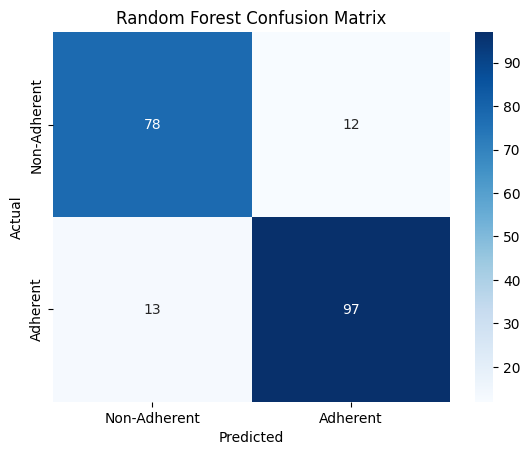

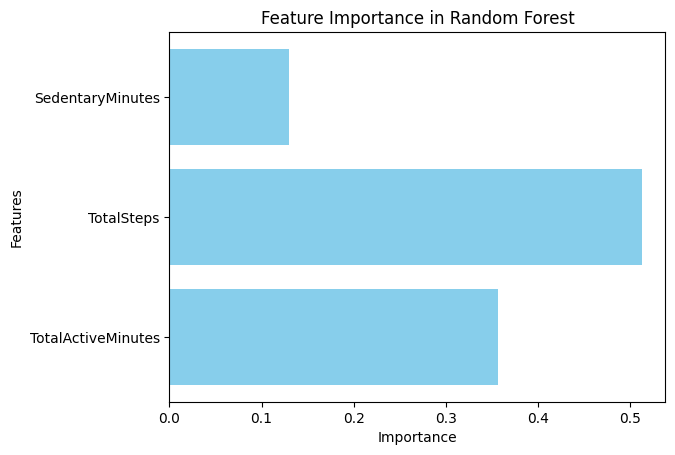


Prediction for a New Week:
Adherent
Probability of Adherence: 0.7446


In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load JSON Data
with open('improved_synthetic_fitbit_data.json', 'r') as f:
    data = json.load(f)

# Step 2: Flatten the JSON Data
flattened_data = []
for participant in data:
    for key, activities in participant.items():
        for activity in activities:
            activity['Participant'] = key  # Add participant ID
            flattened_data.append(activity)

# Convert the flattened data into a DataFrame
df = pd.DataFrame(flattened_data)

# Ensure 'ActivityDate' is a datetime object
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])

# Step 3: Add a Week Number for Each Participant
df['Week'] = df.groupby('Participant')['ActivityDate'].rank().apply(lambda x: int((x - 1) // 7) + 1)

# Step 4: Define Weekly Adherence Logic with Adjusted Active Days Threshold
def weekly_adherence(group):
    """
    Calculate weekly adherence for a group of up to 7 days.
    Adjust active days threshold dynamically based on available days.
    """
    total_steps = group['TotalSteps'].mean()  # Average daily steps
    total_moderate_minutes = group['FairlyActiveMinutes'].sum() + group['LightlyActiveMinutes'].sum()
    total_vigorous_minutes = group['VeryActiveMinutes'].sum()
    total_minutes = total_moderate_minutes + (2 * total_vigorous_minutes)

    # Active days with at least 10 minutes of aerobic activity
    active_days = group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
    total_days = group.shape[0]
    required_active_days = max(1, int(np.ceil(0.7 * total_days)))  # Adjust threshold dynamically

    meets_activity_minutes = total_minutes >= 150
    meets_steps = total_steps >= 8000
    meets_distribution = active_days >= required_active_days

    return int(meets_activity_minutes and meets_steps and meets_distribution)

# Step 5: Calculate Weekly Adherence
weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')

# Merge adherence results back to the DataFrame
df = pd.merge(df, weekly_adherence_data, on=['Participant', 'Week'])

# Step 6: Classify Participant Adherence Based on 70% Weekly Adherence Threshold
def classify_participant_adherence(group):
    """
    Classify participant as adherent if at least 70% of their weeks are adherent.
    """
    adherence_rate = group['WeeklyAdherence'].mean()
    return int(adherence_rate >= 0.7)

participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')

# Merge participant-level adherence back to the DataFrame
df = pd.merge(df, participant_adherence, on='Participant')

# Step 7: Prepare Data for Random Forest Modeling
weekly_summary = df.groupby(['Participant', 'Week']).agg({
    'TotalSteps': 'mean',
    'VeryActiveMinutes': 'sum',
    'FairlyActiveMinutes': 'sum',
    'SedentaryMinutes': 'mean',
    'WeeklyAdherence': 'max'
}).reset_index()

weekly_summary['TotalActiveMinutes'] = (
    weekly_summary['VeryActiveMinutes'] +
    weekly_summary['FairlyActiveMinutes']
)

X = weekly_summary[['TotalActiveMinutes', 'TotalSteps', 'SedentaryMinutes']]
y = weekly_summary['WeeklyAdherence']

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Standardize Features (AFTER Splitting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, class_weight="balanced")
rf_model.fit(X_train_scaled, y_train)

# Step 11: Evaluate the Random Forest Model
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Function
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("\n--- Evaluation Metrics ---")

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Call Evaluation Function
evaluate_model(y_test, y_pred, y_pred_proba)

# Confusion Matrix
rf_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Adherent', 'Adherent'], yticklabels=['Non-Adherent', 'Adherent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Step 12: Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns

plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()

# Step 13: Predict for a New Week
new_week_data = pd.DataFrame({
    'TotalActiveMinutes': [500],  # Example input: total active minutes
    'TotalSteps': [8500],         # Example input: average steps
    'SedentaryMinutes': [400]     # Example input: sedentary time
})

new_week_data_scaled = scaler.transform(new_week_data)
adherence_prediction = rf_model.predict(new_week_data_scaled)
adherence_proba = rf_model.predict_proba(new_week_data_scaled)[:, 1]
print("\nPrediction for a New Week:")
print("Adherent" if adherence_prediction[0] == 1 else "Non-Adherent")
print(f"Probability of Adherence: {adherence_proba[0]:.4f}")


LR

<ipython-input-16-a7abf16bad31>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')
<ipython-input-16-a7abf16bad31>:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence


--- Evaluation Metrics ---
Accuracy: 0.7750
Precision: 0.7439
Recall: 0.7176
F1-Score: 0.7305
Balanced Accuracy: 0.7675
AUC-ROC: 0.8972

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       115
           1       0.74      0.72      0.73        85

    accuracy                           0.78       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.78      0.77       200



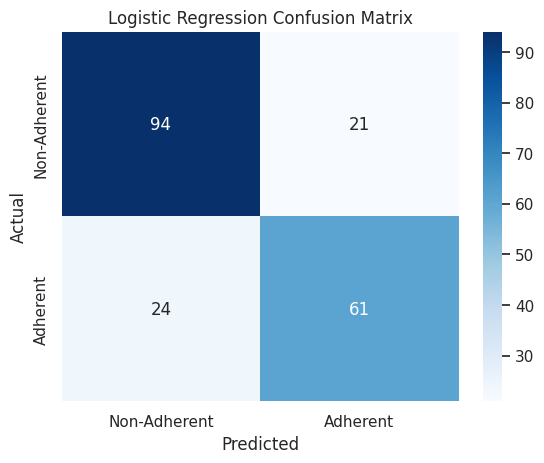


Prediction for a New Week:
Adherent
Probability of Adherence: 0.9478


In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load JSON Data
with open('improved_synthetic_fitbit_data.json', 'r') as f:
    data = json.load(f)

# Step 2: Flatten the JSON Data
flattened_data = []
for participant in data:
    for key, activities in participant.items():
        for activity in activities:
            activity['Participant'] = key  # Add participant ID
            flattened_data.append(activity)

# Convert the flattened data into a DataFrame
df = pd.DataFrame(flattened_data)

# Ensure 'ActivityDate' is a datetime object
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])

# Step 3: Add a Week Number for Each Participant
df['Week'] = df.groupby('Participant')['ActivityDate'].rank().apply(lambda x: int((x - 1) // 7) + 1)

# Step 4: Define Weekly Adherence Logic with Adjusted Active Days Threshold
def weekly_adherence(group):
    """
    Calculate weekly adherence for a group of up to 7 days.
    Adjust active days threshold dynamically based on available days.
    """
    total_steps = group['TotalSteps'].mean()  # Average daily steps
    total_moderate_minutes = group['FairlyActiveMinutes'].sum() + group['LightlyActiveMinutes'].sum()
    total_vigorous_minutes = group['VeryActiveMinutes'].sum()
    total_minutes = total_moderate_minutes + (2 * total_vigorous_minutes)

    # Active days with at least 10 minutes of aerobic activity
    active_days = group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
    total_days = group.shape[0]
    required_active_days = max(1, int(np.ceil(0.7 * total_days)))  # Adjust threshold dynamically

    meets_activity_minutes = total_minutes >= 150
    meets_steps = total_steps >= 8000
    meets_distribution = active_days >= required_active_days

    return int(meets_activity_minutes and meets_steps and meets_distribution)

# Step 5: Calculate Weekly Adherence
weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')

# Merge adherence results back to the DataFrame
df = pd.merge(df, weekly_adherence_data, on=['Participant', 'Week'])

# Step 6: Classify Participant Adherence Based on 70% Weekly Adherence Threshold
def classify_participant_adherence(group):
    """
    Classify participant as adherent if at least 70% of their weeks are adherent.
    """
    adherence_rate = group['WeeklyAdherence'].mean()
    return int(adherence_rate >= 0.7)

participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')

# Merge participant-level adherence back to the DataFrame
df = pd.merge(df, participant_adherence, on='Participant')

# Step 7: Prepare Data for Logistic Regression Modeling
weekly_summary = df.groupby(['Participant', 'Week']).agg({
    'TotalSteps': 'mean',
    'VeryActiveMinutes': 'sum',
    'FairlyActiveMinutes': 'sum',
    'SedentaryMinutes': 'mean',
    'WeeklyAdherence': 'max'
}).reset_index()

weekly_summary['TotalActiveMinutes'] = (
    weekly_summary['VeryActiveMinutes'] +
    weekly_summary['FairlyActiveMinutes']
)

X = weekly_summary[['TotalActiveMinutes', 'TotalSteps', 'SedentaryMinutes']]
y = weekly_summary['WeeklyAdherence']

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Standardize Features (AFTER Splitting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Train Logistic Regression Model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

# Step 11: Evaluate the Logistic Regression Model
y_pred = logreg_model.predict(X_test_scaled)
y_pred_proba = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Function
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("\n--- Evaluation Metrics ---")

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Call Evaluation Function
evaluate_model(y_test, y_pred, y_pred_proba)

# Confusion Matrix
lr_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Adherent', 'Adherent'], yticklabels=['Non-Adherent', 'Adherent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Step 12: Predict for a New Week
new_week_data = pd.DataFrame({
    'TotalActiveMinutes': [500],  # Example input: total active minutes
    'TotalSteps': [8500],         # Example input: average steps
    'SedentaryMinutes': [400]     # Example input: sedentary time
})

new_week_data_scaled = scaler.transform(new_week_data)
adherence_prediction = logreg_model.predict(new_week_data_scaled)
adherence_proba = logreg_model.predict_proba(new_week_data_scaled)[:, 1]
print("\nPrediction for a New Week:")
print("Adherent" if adherence_prediction[0] == 1 else "Non-Adherent")
print(f"Probability of Adherence: {adherence_proba[0]:.4f}")


SVM

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load JSON Data
with open('improved_synthetic_fitbit_data.json', 'r') as f:
    data = json.load(f)

# Step 2: Flatten the JSON Data
flattened_data = []
for participant in data:
    for key, activities in participant.items():
        for activity in activities:
            activity['Participant'] = key  # Add participant ID
            flattened_data.append(activity)

# Convert the flattened data into a DataFrame
df = pd.DataFrame(flattened_data)

# Ensure 'ActivityDate' is a datetime object
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])

# Step 3: Add a Week Number for Each Participant
df['Week'] = df.groupby('Participant')['ActivityDate'].rank().apply(lambda x: int((x - 1) // 7) + 1)

# Step 4: Define Weekly Adherence Logic with Adjusted Active Days Threshold
def weekly_adherence(group):
    """
    Calculate weekly adherence for a group of up to 7 days.
    Adjust active days threshold dynamically based on available days.
    """
    total_steps = group['TotalSteps'].mean()  # Average daily steps
    total_moderate_minutes = group['FairlyActiveMinutes'].sum() + group['LightlyActiveMinutes'].sum()
    total_vigorous_minutes = group['VeryActiveMinutes'].sum()
    total_minutes = total_moderate_minutes + (2 * total_vigorous_minutes)

    # Active days with at least 10 minutes of aerobic activity
    active_days = group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
    total_days = group.shape[0]
    required_active_days = max(1, int(np.ceil(0.7 * total_days)))  # Adjust threshold dynamically

    meets_activity_minutes = total_minutes >= 150
    meets_steps = total_steps >= 8000
    meets_distribution = active_days >= required_active_days

    return int(meets_activity_minutes and meets_steps and meets_distribution)

# Step 5: Calculate Weekly Adherence
weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')

# Merge adherence results back to the DataFrame
df = pd.merge(df, weekly_adherence_data, on=['Participant', 'Week'])

# Step 6: Classify Participant Adherence Based on 70% Weekly Adherence Threshold
def classify_participant_adherence(group):
    """
    Classify participant as adherent if at least 70% of their weeks are adherent.
    """
    adherence_rate = group['WeeklyAdherence'].mean()
    return int(adherence_rate >= 0.7)

participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')

# Merge participant-level adherence back to the DataFrame
df = pd.merge(df, participant_adherence, on='Participant')

# Step 7: Prepare Data for SVM Modeling
weekly_summary = df.groupby(['Participant', 'Week']).agg({
    'TotalSteps': 'mean',
    'VeryActiveMinutes': 'sum',
    'FairlyActiveMinutes': 'sum',
    'SedentaryMinutes': 'mean',
    'WeeklyAdherence': 'max'
}).reset_index()

weekly_summary['TotalActiveMinutes'] = (
    weekly_summary['VeryActiveMinutes'] +
    weekly_summary['FairlyActiveMinutes']
)

X = weekly_summary[['TotalActiveMinutes', 'TotalSteps', 'SedentaryMinutes']]
y = weekly_summary['WeeklyAdherence']

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Standardize Features (AFTER Splitting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Train SVM Model
svm_model = SVC(kernel='rbf', random_state=42, probability=True)  # Enable probability estimation
svm_model.fit(X_train_scaled, y_train)

# Step 11: Evaluate the SVM Model
y_pred = svm_model.predict(X_test_scaled)
y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]  # Use predict_proba for AUC-ROC

# Evaluation Function
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("\n--- Evaluation Metrics ---")

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Call Evaluation Function
evaluate_model(y_test, y_pred, y_pred_proba)

# Confusion Matrix
svm_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Adherent', 'Adherent'], yticklabels=['Non-Adherent', 'Adherent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

# Step 12: Predict for a New Week
new_week_data = pd.DataFrame({
    'TotalActiveMinutes': [500],  # Example input: total active minutes
    'TotalSteps': [8500],         # Example input: average steps
    'SedentaryMinutes': [400]     # Example input: sedentary time
})

new_week_data_scaled = scaler.transform(new_week_data)
adherence_prediction = svm_model.predict(new_week_data_scaled)
adherence_proba = svm_model.predict_proba(new_week_data_scaled)[:, 1]
print("\nPrediction for a New Week:")
print("Adherent" if adherence_prediction[0] == 1 else "Non-Adherent")
print(f"Probability of Adherence: {adherence_proba[0]:.4f}")



k-NN

In [ ]:
# Step 10: Train k-NN Model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
knn_model.fit(X_train_scaled, y_train)

# Step 11: Evaluate the k-NN Model
y_pred = knn_model.predict(X_test_scaled)

# Check if predict_proba is available for AUC-ROC
if hasattr(knn_model, "predict_proba"):
    y_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
else:
    # If predict_proba is not available, AUC-ROC cannot be calculated
    y_pred_proba = None
    print("Warning: k-NN does not support probability prediction. AUC-ROC cannot be calculated.")

# Evaluation Function
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("\n--- Evaluation Metrics ---")

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # AUC-ROC
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        print(f"AUC-ROC: {auc_roc:.4f}")
    else:
        print("AUC-ROC: Not applicable for k-NN without probability support.")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Call Evaluation Function
evaluate_model(y_test, y_pred, y_pred_proba)

# Confusion Matrix
knn_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Adherent', 'Adherent'], yticklabels=['Non-Adherent', 'Adherent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()

# Step 12: Predict for a New Week
new_week_data = pd.DataFrame({
    'TotalActiveMinutes': [500],  # Example input: total active minutes
    'TotalSteps': [8500],         # Example input: average steps
    'SedentaryMinutes': [400]     # Example input: sedentary time
})

new_week_data_scaled = scaler.transform(new_week_data)
adherence_prediction = knn_model.predict(new_week_data_scaled)

if hasattr(knn_model, "predict_proba"):
    adherence_proba = knn_model.predict_proba(new_week_data_scaled)[:, 1]
    print(f"Probability of Adherence: {adherence_proba[0]:.4f}")
else:
    print("Probability of Adherence: Not available for k-NN.")

print("\nPrediction for a New Week:")
print("Adherent" if adherence_prediction[0] == 1 else "Non-Adherent")


NB

<ipython-input-7-723ab02a4b4c>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')
<ipython-input-7-723ab02a4b4c>:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')


--- Evaluation Metrics ---
Accuracy: 0.8250
Precision: 0.9032
Recall: 0.7636
F1-Score: 0.8276
Balanced Accuracy: 0.8318
AUC-ROC: 0.9181

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82        90
           1       0.90      0.76      0.83       110

    accuracy                           0.82       200
   macro avg       0.83      0.83      0.82       200
weighted avg       0.84      0.82      0.83       200



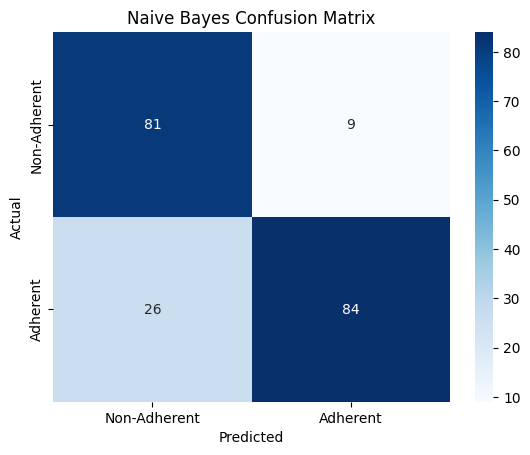


Prediction for a New Week:
Non-Adherent
Probability of Adherence: 0.4722


In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load JSON Data
with open('improved_synthetic_fitbit_data.json', 'r') as f:
    data = json.load(f)

# Step 2: Flatten the JSON Data
flattened_data = []
for participant in data:
    for key, activities in participant.items():
        for activity in activities:
            activity['Participant'] = key  # Add participant ID
            flattened_data.append(activity)

# Convert the flattened data into a DataFrame
df = pd.DataFrame(flattened_data)

# Ensure 'ActivityDate' is a datetime object
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])

# Step 3: Add a Week Number for Each Participant
df['Week'] = df.groupby('Participant')['ActivityDate'].rank().apply(lambda x: int((x - 1) // 7) + 1)

# Step 4: Define Weekly Adherence Logic with Adjusted Active Days Threshold
def weekly_adherence(group):
    """
    Calculate weekly adherence for a group of up to 7 days.
    Adjust active days threshold dynamically based on available days.
    """
    total_steps = group['TotalSteps'].mean()  # Average daily steps
    total_moderate_minutes = group['FairlyActiveMinutes'].sum() + group['LightlyActiveMinutes'].sum()
    total_vigorous_minutes = group['VeryActiveMinutes'].sum()
    total_minutes = total_moderate_minutes + (2 * total_vigorous_minutes)

    # Active days with at least 10 minutes of aerobic activity
    active_days = group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
    total_days = group.shape[0]
    required_active_days = max(1, int(np.ceil(0.7 * total_days)))  # Adjust threshold dynamically

    meets_activity_minutes = total_minutes >= 150
    meets_steps = total_steps >= 8000
    meets_distribution = active_days >= required_active_days

    return int(meets_activity_minutes and meets_steps and meets_distribution)

# Step 5: Calculate Weekly Adherence
weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')

# Merge adherence results back to the DataFrame
df = pd.merge(df, weekly_adherence_data, on=['Participant', 'Week'])

# Step 6: Classify Participant Adherence Based on 70% Weekly Adherence Threshold
def classify_participant_adherence(group):
    """
    Classify participant as adherent if at least 70% of their weeks are adherent.
    """
    adherence_rate = group['WeeklyAdherence'].mean()
    return int(adherence_rate >= 0.7)

participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')

# Merge participant-level adherence back to the DataFrame
df = pd.merge(df, participant_adherence, on='Participant')

# Step 7: Prepare Data for Naive Bayes Modeling
weekly_summary = df.groupby(['Participant', 'Week']).agg({
    'TotalSteps': 'mean',
    'VeryActiveMinutes': 'sum',
    'FairlyActiveMinutes': 'sum',
    'SedentaryMinutes': 'mean',
    'WeeklyAdherence': 'max'
}).reset_index()

weekly_summary['TotalActiveMinutes'] = (
    weekly_summary['VeryActiveMinutes'] +
    weekly_summary['FairlyActiveMinutes']
)

X = weekly_summary[['TotalActiveMinutes', 'TotalSteps', 'SedentaryMinutes']]
y = weekly_summary['WeeklyAdherence']

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Standardize Features (AFTER Splitting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Train Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Step 11: Evaluate the Naive Bayes Model
y_pred = nb_model.predict(X_test_scaled)
y_pred_proba = nb_model.predict_proba(X_test_scaled)[:, 1]  # Extract probabilities for AUC-ROC calculation

def evaluate_model(y_true, y_pred, y_pred_proba):
    print("\n--- Evaluation Metrics ---")

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Call Evaluation Function
evaluate_model(y_test, y_pred, y_pred_proba)

# Confusion Matrix
nb_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Adherent', 'Adherent'], yticklabels=['Non-Adherent', 'Adherent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Step 12: Predict for a New Week
new_week_data = pd.DataFrame({
    'TotalActiveMinutes': [500],  # Example input: total active minutes
    'TotalSteps': [8500],         # Example input: average steps
    'SedentaryMinutes': [400]     # Example input: sedentary time
})

new_week_data_scaled = scaler.transform(new_week_data)
adherence_prediction = nb_model.predict(new_week_data_scaled)
adherence_proba = nb_model.predict_proba(new_week_data_scaled)[:, 1]
print("\nPrediction for a New Week:")
print("Adherent" if adherence_prediction[0] == 1 else "Non-Adherent")
print(f"Probability of Adherence: {adherence_proba[0]:.4f}")


RF for web-app deployment

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load JSON Data
with open('improved_synthetic_fitbit_data.json', 'r') as f:
    data = json.load(f)

# Step 2: Flatten the JSON Data
flattened_data = []
for participant in data:
    for key, activities in participant.items():
        for activity in activities:
            activity['Participant'] = key  # Add participant ID
            flattened_data.append(activity)

# Convert the flattened data into a DataFrame
df = pd.DataFrame(flattened_data)

# Ensure 'ActivityDate' is a datetime object
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'])

# Step 3: Add a Week Number for Each Participant
df['Week'] = df.groupby('Participant')['ActivityDate'].rank().apply(lambda x: int((x - 1) // 7) + 1)

# Step 4: Define Weekly Adherence Logic with Active Days Condition
def weekly_adherence(group):
    """
    Calculate weekly adherence for a group of up to 7 days.
    Adjust active days threshold dynamically based on available days.
    """
    total_steps = group['TotalSteps'].mean()  # Average daily steps
    total_moderate_minutes = group['FairlyActiveMinutes'].sum() + group['LightlyActiveMinutes'].sum()
    total_vigorous_minutes = group['VeryActiveMinutes'].sum()
    total_minutes = total_moderate_minutes + (2 * total_vigorous_minutes)

    # Active days with at least 10 minutes of aerobic activity
    active_days = group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
    total_days = group.shape[0]
    required_active_days = max(1, int(np.ceil(0.7 * total_days)))  # Adjust threshold dynamically

    meets_activity_minutes = total_minutes >= 150
    meets_steps = total_steps >= 8000
    meets_distribution = active_days >= required_active_days

    return int(meets_activity_minutes and meets_steps and meets_distribution)

# Step 5: Calculate Weekly Adherence
weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')

# Merge adherence results back to the DataFrame
df = pd.merge(df, weekly_adherence_data, on=['Participant', 'Week'])


def weekly_adherence(group):
    """
    Calculate weekly adherence for a group of up to 7 days.
    Adjust active days threshold dynamically based on available days.
    """
    total_steps = group['TotalSteps'].mean()  # Average daily steps
    total_moderate_minutes = group['FairlyActiveMinutes'].sum() + group['LightlyActiveMinutes'].sum()
    total_vigorous_minutes = group['VeryActiveMinutes'].sum()
    total_minutes = total_moderate_minutes + (2 * total_vigorous_minutes)

    # Active days with at least 10 minutes of aerobic activity
    active_days = group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
    total_days = group.shape[0]

    # Ensure required active days align with logic (70% threshold)
    required_active_days = max(1, int(np.ceil(0.7 * total_days)))  # Adjust threshold dynamically

    # Strict thresholds for adherence
    meets_activity_minutes = total_minutes >= 150
    meets_steps = total_steps >= 8000
    meets_distribution = active_days >= required_active_days

    # Final adherence result
    return int(meets_activity_minutes and meets_steps and meets_distribution)

# Step 6: Classify Participant Adherence Based on 70% Weekly Adherence Threshold
def classify_participant_adherence(group):
    """
    Classify participant as adherent if at least 70% of their weeks are adherent.
    """
    adherence_rate = group['WeeklyAdherence'].mean()
    return int(adherence_rate >= 0.7)

participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')

# Merge participant-level adherence back to the DataFrame
df = pd.merge(df, participant_adherence, on='Participant')

# Step 7: Prepare Data for Random Forest Modeling
weekly_summary = df.groupby(['Participant', 'Week']).agg({
    'TotalSteps': 'mean',
    'VeryActiveMinutes': 'sum',
    'FairlyActiveMinutes': 'sum',
    'SedentaryMinutes': 'mean',
    'WeeklyAdherence': 'max'
}).reset_index()

weekly_summary['TotalActiveMinutes'] = (
    weekly_summary['VeryActiveMinutes'] +
    weekly_summary['FairlyActiveMinutes']
)

weekly_summary['ActiveDays'] = df.groupby(['Participant', 'Week']).apply(
    lambda group: group[(group['FairlyActiveMinutes'] >= 10) | (group['VeryActiveMinutes'] >= 10)].shape[0]
).reset_index(name='ActiveDays')['ActiveDays']

X = weekly_summary[['TotalActiveMinutes', 'TotalSteps', 'SedentaryMinutes', 'ActiveDays']]
y = weekly_summary['WeeklyAdherence']

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Standardize Features (AFTER Splitting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 10: Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, class_weight="balanced")
rf_model.fit(X_train_scaled, y_train)

# Save the trained model and scaler
with open("rf_model.pkl", "wb") as model_file:
    pickle.dump(rf_model, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler files saved!")

# Step 11: Evaluate the Random Forest Model
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
print("\n--- Evaluation Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


<ipython-input-6-6e5e4df17314>:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_adherence_data = df.groupby(['Participant', 'Week']).apply(weekly_adherence).reset_index(name='WeeklyAdherence')
<ipython-input-6-6e5e4df17314>:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  participant_adherence = df.groupby('Participant').apply(classify_participant_adherence).reset_index(name='ParticipantAdherence')

Model and scaler files saved!

--- Evaluation Metrics ---
Accuracy: 0.9800
Precision: 1.0000
Recall: 0.9636
F1-Score: 0.9815
AUC-ROC: 0.9985


Streamlit configuration

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


Code to save in file streamlit_app.py

In [ ]:
import pickle
import streamlit as st
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the trained model and scaler
with open("rf_model.pkl", "rb") as model_file:
    rf_model = pickle.load(model_file)

with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)

st.title("Adherence to lifestyle prediction App")
st.write("Predict weekly adherence based on activity data.")


# Input form (example data)
st.sidebar.header("Input Data")
total_active_minutes = st.sidebar.number_input("Total Active Minutes", min_value=0, value=300)
total_steps = st.sidebar.number_input("Total Steps", min_value=0, value=8500)
sedentary_minutes = st.sidebar.number_input("Sedentary Minutes", min_value=0, value=400)
active_days = st.sidebar.number_input("Active Days (>=10 min activity)", min_value=0, max_value=7, value=5)

# Prepare input data
new_data = pd.DataFrame({
    'TotalActiveMinutes': [total_active_minutes],
    'TotalSteps': [total_steps],
    'SedentaryMinutes': [sedentary_minutes],
    'ActiveDays': [active_days]
})

# Scale input data
new_data_scaled = scaler.transform(new_data)

# Predict adherence
adherence_prediction = rf_model.predict(new_data_scaled)
adherence_proba = rf_model.predict_proba(new_data_scaled)[:, 1]

# Display results for output
st.subheader("Prediction Results")
if adherence_prediction[0] == 1:
    st.success("Adherent")
else:
    st.error("Non-Adherent")

st.write(f"Probability of Adherence: {adherence_proba[0]:.4f}")



2025-01-08 13:58:16.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.131 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.137 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-08 13:58:16.148 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Example: Simulate data for demonstration (replace with your actual data)
data = {
    'TotalActiveMinutes': [500, 300, 700, 200],
    'TotalSteps': [8000, 4000, 10000, 2000],
    'SedentaryMinutes': [400, 600, 300, 700],
    'WeeklyAdherence': [1, 0, 1, 0]
}

df = pd.DataFrame(data)

# Features and target
X = df[['TotalActiveMinutes', 'TotalSteps', 'SedentaryMinutes']]
y = df['WeeklyAdherence']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, class_weight="balanced")
rf_model.fit(X_scaled, y)

# Save the trained model and scaler
with open("rf_model.pkl", "wb") as model_file:
    pickle.dump(rf_model, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler files have been saved successfully!")


Model and scaler files have been saved successfully!


In [ ]:
!streamlit run streamlit_app.py
!git add requirements.txt
!git commit -m "Add requirements file"
!git push origin main


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
